<a href="https://colab.research.google.com/github/Weverton-Vitor/semantic-segmentation-unet/blob/main/semantic_segmentation_of_cells_on_microscope_images_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Cells On Microscope Images using UNet

## 0. Imports and install packeges

In [1]:
!pip install torchinfo
!pip install torchmetrics
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.8 MB/s eta 0:00:00


In [2]:
import os
import shutil
import zipfile
import random
import json
from typing import Tuple

import numpy as np
import skimage
import tifffile

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision.datasets import CocoDetection
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF


from torchmetrics.detection import IntersectionOverUnion
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy

import pycocotools.mask as coco_mask

from torchinfo import summary

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches


## 1. Get the dataset

### 1.1 Donwload images

In [3]:
os.environ['KAGGLE_USERNAME'] = 'gabevr'
os.environ['KAGGLE_KEY'] = 'ca479e66ac6ae221b62be68f056aca65'

In [4]:
!kaggle competitions download -c data-science-bowl-2018

 95% 341M/358M [00:02<00:00, 185MB/s]
100% 358M/358M [00:02<00:00, 130MB/s]


In [5]:
!unzip data-science-bowl-2018.zip

Archive:  data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [6]:
!unzip stage1_train.zip -d /content/train/ &> /dev/null
!unzip stage1_test.zip -d /content/test/ &> /dev/null

### 1.2 Create custom datasets and Visualizing random images of dataset

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, path, transform=None, target_transform=None, train=True):
        self.path = path
        self.is_train = train
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(next(os.walk(self.path))[1])

    def __getitem__(self, idx):
        # Get the image in its directory
        img_name, img = self.get_image_by_index(idx)

        w, h = img.size

        mask = None

        if self.is_train:
          masks = next(os.walk(f'{self.path}/{img_name}/masks'))[2]
          mask = np.zeros((h, w), dtype=np.uint8)
          for mask_name in masks:
            m = Image.open(f'{self.path}/{img_name}/masks/{mask_name}')
            mask += np.array(m)

          mask = Image.fromarray(mask)
          if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

            #random vertical flip
          if random.random() > 0.5:
            img = TF.vflip(img)
            mask = TF.vflip(mask)

            #random rotation
            img = TF.rotate(img, angle=10.0)
            mask = TF.rotate(mask, angle=10.0)

        img = self.transform(img)

        if mask is not None:
          mask = self.target_transform(mask)
        return img, mask

    def get_image_by_index(self, idx) -> tuple:
      img_name = next(os.walk(self.path))[1][idx]
      img_path = f'{self.path}/{img_name}/images/{img_name}.png'
      img = Image.open(img_path)

      return img_name, img

    def show_random_samples(self, qty: int=5) -> None:
      random_samples = random.sample(range(self.__len__()), k=qty)

      fig = plt.figure(figsize=(15, 15))

      for i, sample in enumerate(random_samples):
        fig.add_subplot(1, qty, i+1)
        _, img = self.get_image_by_index(sample)
        img = self.transform(img)
        plt.imshow(img.permute(1, 2, 0),  cmap='gray')
        plt.axis('off')


In [8]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(1),
    transforms.ToTensor()
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

])

target_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [9]:
# Train, Val and Test images and annotation paths
train_dataset_image_path = '/content/train'
test_dataset_image_path = '/content/test'

In [10]:
# Train dataset (only 5%)
train_dataset = SegmentationDataset(path=train_dataset_image_path,
                                        transform=transform,
                                        target_transform=target_transform,
                                       train=True)

In [11]:
test_dataset = SegmentationDataset(path=test_dataset_image_path,
                                      transform=transform,
                                      target_transform=target_transform,
                                      train=False)

In [12]:
len(train_dataset), len(test_dataset)

(670, 65)

In [13]:
train_dataset[10][0].shape, train_dataset[10][1].shape

(torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))

In [14]:
test_dataset[10][0].shape, test_dataset[10][1]

(torch.Size([1, 512, 512]), None)

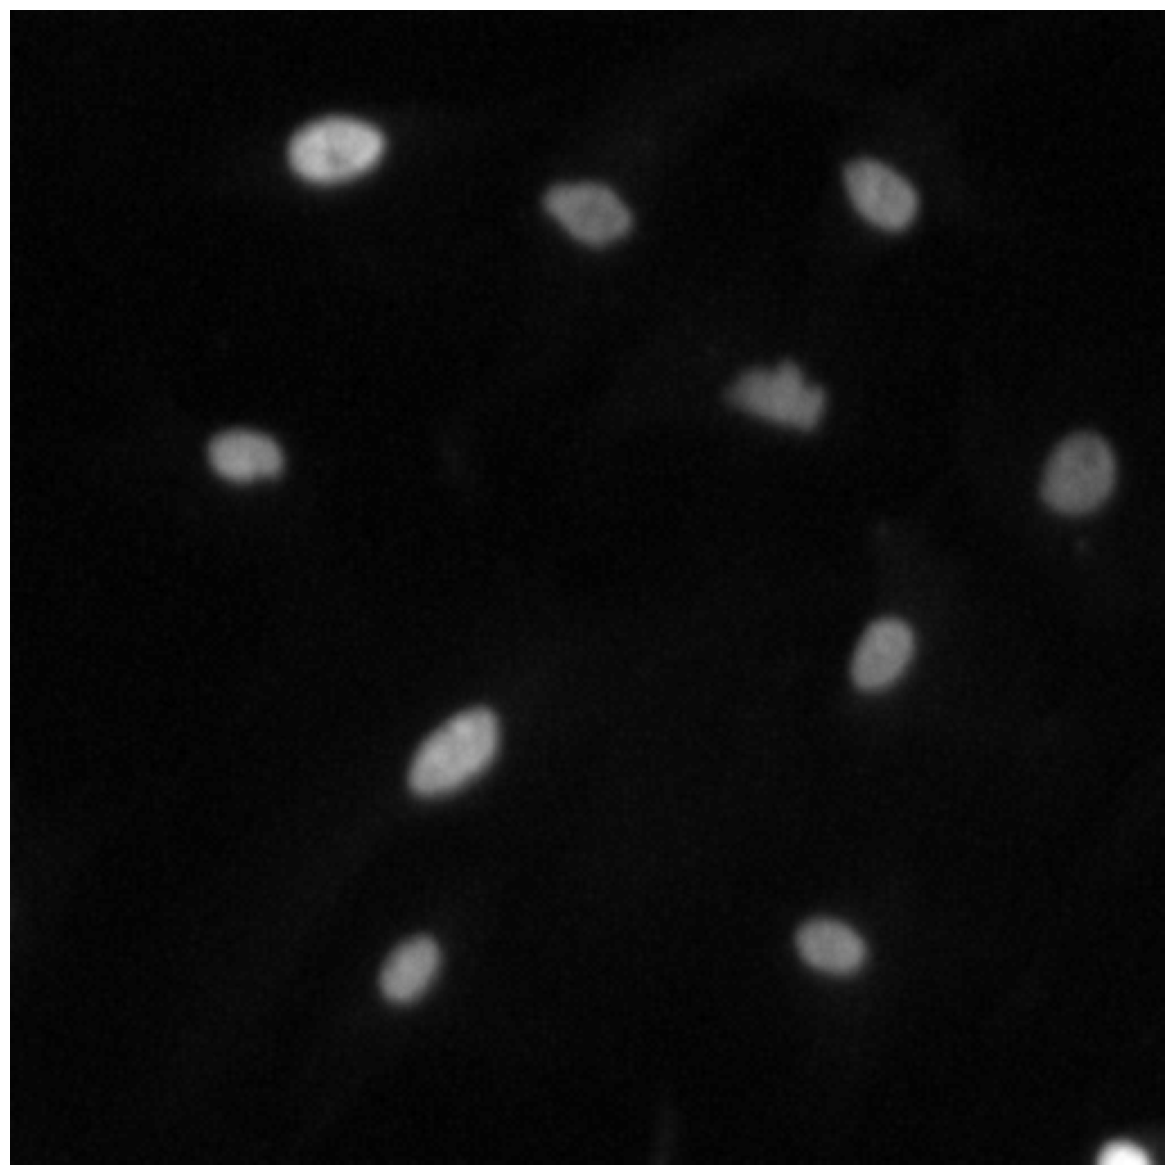

In [15]:
train_dataset.show_random_samples(qty=1)

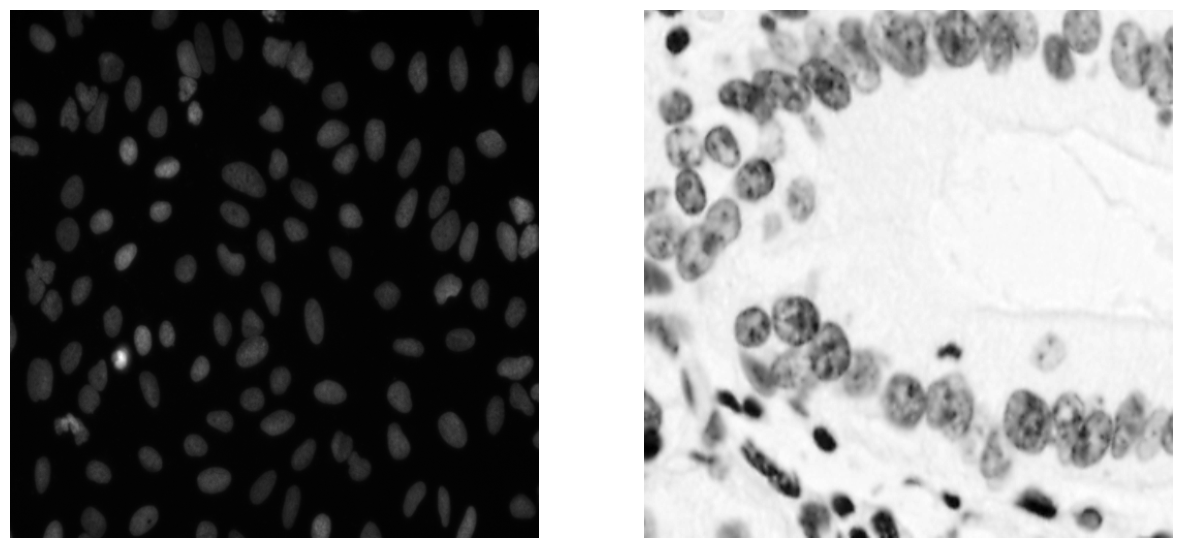

In [16]:
train_dataset.show_random_samples(qty=2)

### 1.3 Visualizing the maks segmentation

In [17]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [18]:
def show_random_masks(dataset: datasets.CocoDetection, qty: int=5) -> None:
  random_masks = random.sample(range(len(dataset)), k=qty)

  fig = plt.figure(figsize=(15, 15))

  for i, mask in enumerate(random_masks):
    fig.add_subplot(1, qty, i+1)
    plt.imshow(dataset[mask][1].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
  plt.show()

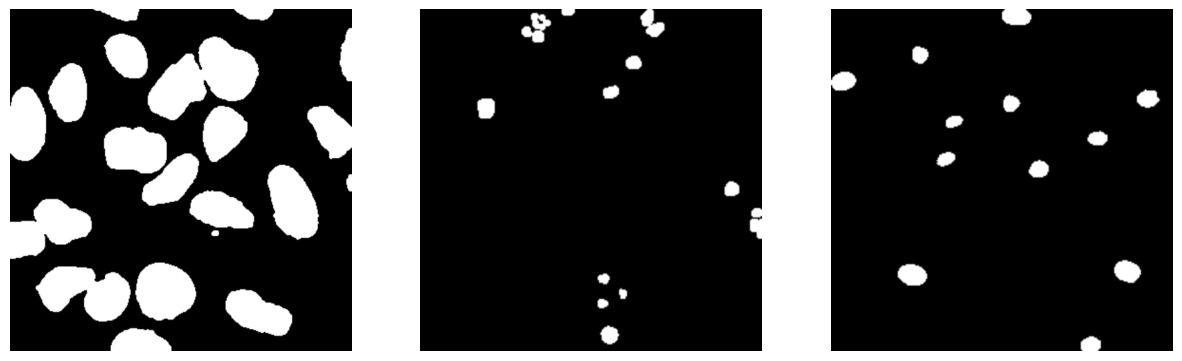

In [19]:
show_random_masks(dataset=train_dataset, qty=3)

### 1.4 Visualizing random images and its respective masks

In [23]:
def show_random_image_and_mask(dataset: datasets.CocoDetection) -> None:
  random_sample = random.choice(range(len(dataset)))
  random_sample = dataset[random_sample]

  fig = plt.figure(figsize=(15, 15))

  fig.add_subplot(1, 2, 1)
  plt.imshow(random_sample[0].permute(1, 2, 0), cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  fig.add_subplot(1, 2, 2)
  plt.imshow(random_sample[1].permute(1, 2, 0), cmap='gray')
  plt.title('Mask')

  plt.axis('off')
  plt.show()

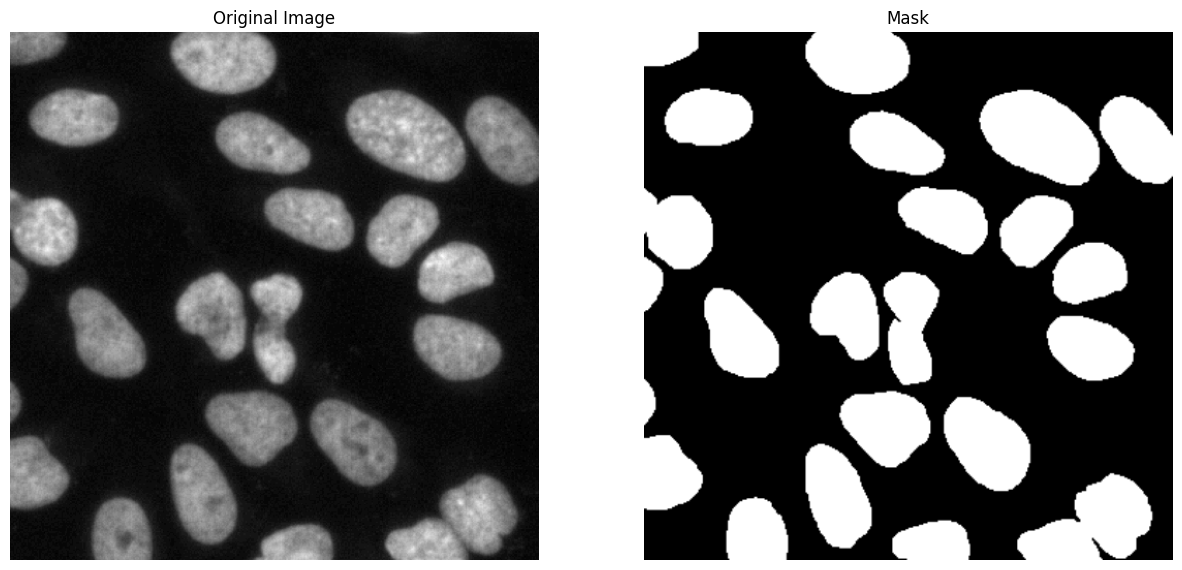

In [26]:
show_random_image_and_mask(train_dataset)

### 1.5 Generate DataLoader and tranforms images with torchvision

#### 1.5.1 Device Agnostic

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

#### 1.5.2 Create DataLoaders

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=8,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=8)

In [ ]:
next(iter(train_dataloader))

In [ ]:
next(iter(train_dataloader))[0].shape,  next(iter(train_dataloader))[1].shape

## 2. Build Unet

Original Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

![](https://developers.arcgis.com/python/guide/images/unet.png)


### 2.1 Encoder

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*xbG7s8urH-QcsHokMsj85Q.png)

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_filters: int=3, out_filters: int=64, kernel_size=(3, 3)):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=in_filters,
                  out_channels=out_filters,
                  kernel_size=kernel_size),
        nn.ReLU(),

        nn.Conv2d(in_channels=out_filters,
                  out_channels=out_filters,
                  kernel_size=kernel_size),
        nn.ReLU()
    )

  def forward(self, x):
    return self.conv_block(x)


In [ ]:
class EncoderMiniBlock(nn.Module):
  def __init__(self, in_filters: int=3, out_filters: int=64):
    super().__init__()
    self.conv_block = ConvBlock(in_filters=in_filters,
                                out_filters=out_filters,
                                kernel_size=(3, 3))

    self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

  def forward(self, x):
    self.skip_features = self.conv_block(x)
    x = self.max_pooling(self.skip_features)
    # print(f"Encode Shape Output: {x.shape}")
    return x


### 2.2 Decoder

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*LDJ4y5QJc_eCr7quukcKkg.png)

In [ ]:
class DecoderMiniBlock(nn.Module):

  def __init__(self, in_filters, out_filters):
    super().__init__()
    # self.ina = in_filters
    # self.outa = out_filters
    self.up_conv = nn.ConvTranspose2d(in_channels=in_filters,
                                 out_channels=out_filters,
                                 kernel_size=(2, 2),
                                 stride=(2, 2))

    self.conv_block = ConvBlock(in_filters=in_filters,
                                out_filters=out_filters,
                                kernel_size=(3, 3))

  def forward(self, x, skip_features):
    # print('before: ', x.shape, skip_features.shape, self.ina, self.outa)
    x = self.up_conv(x)
    # print("After upconv", x.shape, skip_features.shape)

    #Cortar ou ajustar o tamanho do skip_features para corresponder ao tamanho do decoder_feature
    skip_features_cropped = skip_features[:, :, :x.shape[2], :x.shape[3]]
    # print("skip_features crop: ", skip_features_cropped.shape, 'x: ', x.shape )


    # Concatenar os feature maps
    x = torch.cat([x, skip_features_cropped], dim=1)
    # print('x after concat: ', x.shape)

    x = self.conv_block(x)
    #print(x.shape, in_filters, out_filters)
    # print(f"Decoder Shape Output: {x.shape}")
    return x


### 2.3 UNet Model

In [ ]:
class UNet(nn.Module):
  def __init__(self, base_n_filters, n_classes):
    super().__init__()
    self.base_n_filters = base_n_filters
    self.n_classes = n_classes

    self.encoder_miniblock1 = EncoderMiniBlock(in_filters=1,
                                               out_filters=self.base_n_filters) # 64 filters

    self.encoder_miniblock2 = EncoderMiniBlock(in_filters=self.base_n_filters,
                                               out_filters=self.base_n_filters*2) # 128 filters

    self.encoder_miniblock3 = EncoderMiniBlock(in_filters=self.base_n_filters*2,
                                               out_filters=self.base_n_filters*4) # 256 filters

    self.encoder_miniblock4 = EncoderMiniBlock(in_filters=self.base_n_filters*4,
                                               out_filters=self.base_n_filters*8) # 512 filters

    # Without max_pooling
    self.encoder_miniblock5 = ConvBlock(in_filters=self.base_n_filters*8,
                                        out_filters=self.base_n_filters*16,
                                        kernel_size=(3, 3))

    self.decoder_miniblock1 = DecoderMiniBlock(in_filters=self.base_n_filters*16,
                                               out_filters=self.base_n_filters*8) # 512 filters

    self.decoder_miniblock2 = DecoderMiniBlock(in_filters=self.base_n_filters*8,
                                               out_filters=self.base_n_filters*4) # 256 filters

    self.decoder_miniblock3 = DecoderMiniBlock(in_filters=self.base_n_filters*4,
                                               out_filters=self.base_n_filters*2) # 128 filters

    self.decoder_miniblock4 = DecoderMiniBlock(in_filters=self.base_n_filters*2,
                                               out_filters=self.base_n_filters) # 64 filters

    self.final_conv = nn.Conv2d(in_channels=64,
                  out_channels=self.n_classes,
                  kernel_size=(1, 1))

  def forward(self, x):
    x = self.encoder_miniblock1(x) # 64 filters
    x = self.encoder_miniblock2(x) # 128 filters
    x = self.encoder_miniblock3(x) # 256 filters
    x = self.encoder_miniblock4(x) # 512 filters

    x = self.encoder_miniblock5(x) # 1024 filters
    # print("Encoder Shape Output: ", x.shape)
    x = self.decoder_miniblock1(x, self.encoder_miniblock4.skip_features) # 512 filters
    x = self.decoder_miniblock2(x, self.encoder_miniblock3.skip_features) # 256 filters
    x = self.decoder_miniblock3(x, self.encoder_miniblock2.skip_features) # 128 filters
    x = self.decoder_miniblock4(x, self.encoder_miniblock1.skip_features) # 64 filters

    x = self.final_conv(x) # n_class filters
    return x

In [ ]:
# Create model and send it to target device
unet_model = UNet(base_n_filters=64, n_classes=1)
unet_model.to(device)

#### 2.3.1 Forward pass on a random tensor

In [ ]:
summary(unet_model, input_size=[1,3,572,572])

In [ ]:
print(next(unet_model.parameters()).device)

In [ ]:
# a = torch.rand(size=(32, 3, 572, 572)).to(device)
a = torch.rand(size=(1, 3, 224, 224)).to(device)
a.device

In [ ]:
r = unet_model(a)
r, r.shape

## 3. Train the model

### 3.1 Create train step function

In [ ]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               iou: BinaryJaccardIndex,
              acc: BinaryAccuracy,
               device: str) -> tuple:

  # Send the model to device and set train mode
  model.to(device)
  model.train()

  # Metrics
  total_loss = 0
  total_iou = 0
  total_acc = 0

  # Looping thougtt batchs
  for X, mask in dataloader:
    # Send the data to right device
    X, mask = X.to(device), mask.to(device)


    # Foward pass
    logits = model(X)

    # Resize the result mask
    logits_resized = F.interpolate(logits, size=(mask.shape[2], mask.shape[3]), mode='bilinear', align_corners=False)

    # Pred mask
    pred_mask = torch.softmax(logits_resized, dim=1)
    pred_mask = torch.round(pred_mask).to(device)

    # Loss
    loss = loss_fn(logits_resized, mask)
    total_loss += loss


    total_iou += iou(pred_mask, torch.round(mask)).item()
    total_acc += acc(pred_mask, torch.round(mask)).item()


    # Zero grad
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer step
    optimizer.step()


  # Mean of train loss and IoU
  total_loss /= len(dataloader)
  total_iou /= len(dataloader)
  total_acc /= len(dataloader)

  return total_loss, total_iou, total_acc

### 3.2 Create test step function

In [ ]:
def val_step(model: nn.Module,
             dataloader: DataLoader,
             loss_fn: nn.Module,
             iou: BinaryJaccardIndex,
             acc: BinaryAccuracy,
             device: str) -> tuple:

  loss = 0
  iou_metric = 0
  acc_metric = 0

  # Test with inference mode with validation dataset
  with torch.inference_mode():
    model.eval()
    model.to(device)

    # Looping thougtt batchs
    for X, mask in dataloader:
      # Send the data to right device
      X, mask = X.to(device), mask.to(device)

      # Forward pass
      logits = model(X)

      logits_resized = F.interpolate(logits, size=(mask.shape[2], mask.shape[3]), mode='bilinear', align_corners=False)

      # Test loss
      loss += loss_fn(logits_resized, mask)

      # Pred mask
      pred_mask = torch.softmax(logits_resized, dim=1)
      pred_mask = torch.round(pred_mask).to(device)

      # IoU
      iou_metric += iou(pred_mask, torch.round(mask)).item()

      # Accuracy
      acc_metric += acc(pred_mask, torch.round(mask)).item()



    loss /= len(dataloader)
    iou_metric /= len(dataloader)
    acc_metric /= len(dataloader)


  return loss, iou_metric, acc_metric

### 3.1 Create train function

In [ ]:
def train(epochs:int,
          model: nn.Module,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          iou: BinaryJaccardIndex,
          acc: BinaryAccuracy,
          device) -> dict:

  history_dict = {
      'train_loss': [],
      'val_loss': [],
      'train_iou': [],
      'val_iou': [],
      'train_acc': [],
      'val_acc': [],
  }

  for epoch in range(epochs):
    train_loss, train_iou, train_acc = train_step(model=unet_model,
           dataloader=train_dataloader,
           loss_fn=loss_fn,
           optimizer=optimzier,
           iou=iou,
           acc=acc,
           device=device)

    if val_dataloader is not None:
      val_loss, val_iou, val_acc = val_step(model=unet_model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            iou=iou,
            acc=acc,
            device=device)

      history_dict['val_loss'].append(val_loss.item())
      history_dict['val_iou'].append(val_iou)
      history_dict['val_acc'].append(val_acc)

    history_dict['train_loss'].append(train_loss.item())
    history_dict['train_iou'].append(train_iou)
    history_dict['train_acc'].append(train_acc)

    if val_dataloader is not None:
      print(f"Epoch: {epoch+1} | Train Loss: {train_loss} | Validation Loss: {val_loss} | Train IoU: {train_iou} | Validation IoU: {val_iou} | Train Accuracy: {train_acc} | Validation Accuracy: {val_acc}")
    else:
      print(f"Epoch: {epoch+1} | Train Loss: {train_loss} | Train IoU: {train_iou} | Train Accuracy: {train_acc}")

  return history_dict

### 3.4 Train the model

In [ ]:
# Loss function and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimzier = Adam(unet_model.parameters(), lr=10)

# Metrics
iou_metric = BinaryJaccardIndex().to(device)
accuracy_metric = BinaryAccuracy().to(device)


In [ ]:
history = train(epochs=10,
                model=unet_model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                loss_fn=loss_fn,
                optimizer=optimzier,
                iou=iou_metric,
                acc=accuracy_metric,
                device=device)

### 3.5 Loss, IoU and Accuracy curves


In [ ]:
history

In [ ]:
def plot_iou_and_loss_metrics(history: dict) -> None:

  epochs = len(history['train_loss'])

  fig = plt.figure(figsize=(25, 10))

  fig.add_subplot(1, 2, 1)
  plt.plot(range(epochs), history['train_loss'])
  plt.plot(range(epochs), history['val_loss'])
  plt.title(f'Loss')
  plt.legend()

  fig.add_subplot(1, 2, 2)
  plt.plot(range(epochs), history['train_iou'])
  plt.plot(range(epochs), history['val_iou'])
  plt.title(f'IoU(Intersection Over Union - BinaryJaccardIndex)')
  plt.legend()

#   fig.add_subplot(1, 3, 3)
#   plt.plot(range(epochs), history['train_acc'])
#   plt.plot(range(epochs), history['val_acc'])
#   plt.title(f'Accuracy')
#   plt.legend()

  plt.show()

In [ ]:
plot_iou_and_loss_metrics(history)

In [ ]:
torch.save(unet_model.state_dict(), '/kaggle/working/model.pth')

In [ ]:
  plt.imshow(val_dataset[0][0].permute(1, 2, 0))

In [ ]:
len(val_dataset)

In [ ]:
with torch.inference_mode():
    unet_model.to('cpu')
    from matplotlib import cm
    tensor_image = train_dataset[30][0]
    pil_image = TF.to_pil_image(tensor_image)
    transformed_tensor = transform(pil_image)
    test = unet_model(torch.unsqueeze(transformed_tensor, dim=0))
    plt.imshow(transformed_tensor.permute(1, 2, 0))
    plt.figure()
    plt.imshow(torch.squeeze(test, dim=0).permute(1, 2, 0))


In [ ]:
test.shape, torch.squeeze(test, dim=0).shape